<a href="https://colab.research.google.com/github/HalyaIss/Python-Projects/blob/main/Sales_Analitics_for_online_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Oblective**: To build online store sales analytics using three tools: SQL, Python, and Tableau.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import pearsonr

In [ ]:
!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")

In [ ]:
# SQL-query
query = """
SELECT
   s.date,
   s.ga_session_id,
   sp.continent,
   sp.country,
   sp.device,
   sp.browser,
   sp.mobile_model_name,
   sp.operating_system,
   sp.language,
   sp.name as traffic_source,
   sp.channel,
   acs.account_id,
   a.is_verified,
   a.is_unsubscribed,
   p.category,
   p.name as product_name,
   p.price,
   p.short_description
FROM data-analytics-mate.DA.session s
JOIN data-analytics-mate.DA.session_params sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN data-analytics-mate.DA.account_session acs
ON s.ga_session_id = acs.ga_session_id
LEFT JOIN data-analytics-mate.DA.account a
ON acs.account_id = a.id
LEFT JOIN data-analytics-mate.DA.order o
ON s.ga_session_id = o.ga_session_id
LEFT JOIN data-analytics-mate.DA.product p
ON o.item_id = p.item_id
"""

query_job = client.query(query)
results = query_job.result()

df = results.to_dataframe()

df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,channel,account_id,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [ ]:
# data type conversion
df["ga_session_id"] = df["ga_session_id"].astype("object")
df["account_id"] = df["account_id"].astype("object")
df["is_verified"] = df["is_verified"].astype("object")
df["is_unsubscribed"] = df["is_unsubscribed"].astype("object")

In [ ]:
df.describe()

,price
count,33538.000000
mean,953.298679
std,1317.001775
min,3.000000
25%,170.000000
50%,445.000000
75%,1195.000000
max,9585.000000


In [ ]:
session_cnt = df["ga_session_id"].nunique()
max_date = df["date"].max()
min_date = df["date"].min()
print(session_cnt)
print(max_date)
print(min_date)

349545
2021-01-31
2020-11-01


In [ ]:
print(df.isna().sum())

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
traffic_source            0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      321600
category             316007
product_name         316007
price                316007
short_description    316007
dtype: int64


In [ ]:
print(df.duplicated().sum())

0


Дата сет має 18 колонок та 349545 рядків.
Стовпець price має числовий тип, date - дата. Всі інші стопвці мають текстовий тип даних. Колонки continent, country, device, browser, mobile_model_name, operating_system, language, traffic_sourse, channel, category є категоріальними.

Часовий період датасету з 01.11.2020 по 31.01.2021.

У колонках language, account_id, is_verified, is_unsubscribed, category, product_name, price, short_description маємо досить багато пропущених значень, тому що не у кожній сесії був створенний акаунт та здійснена покупка.


In [ ]:
top_continent = df.groupby("continent")["price"].agg(["sum", "count"]).sort_values(by="sum", ascending=False).reset_index()
print(top_continent)

   continent         sum  count
0   Americas  17665280.0  18553
1       Asia   7601298.3   7950
2     Europe   5934624.2   6261
3    Oceania    365230.2    364
4     Africa    331231.0    339
5  (not set)     74067.4     71


In [ ]:
top_country = df.groupby("country")["price"].agg(["sum", "count"]).sort_values(by="sum", ascending=False).reset_index()
print(top_country)

                  country         sum  count
0           United States  13943553.9  14673
1                   India   2809762.0   3029
2                  Canada   2437921.0   2560
3          United Kingdom    938317.9   1029
4                  France    710692.8    678
..                    ...         ...    ...
103               Bahamas      2411.0      4
104             Guatemala      2259.0      7
105                 Ghana      1018.0      6
106  Bosnia & Herzegovina       939.0      5
107            Luxembourg       879.0      3

[108 rows x 3 columns]


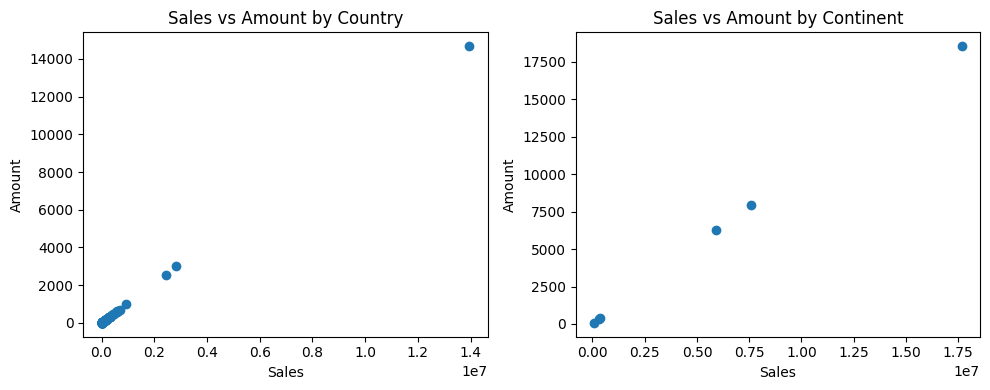

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data=top_country, x="sum", y="count")
ax[0].set_title("Sales vs Amount by Country")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Amount")

ax[1].scatter(data=top_continent, x="sum", y="count")
ax[1].set_title("Sales vs Amount by Continent")
ax[1].set_xlabel("Sales")
ax[1].set_ylabel("Amount")

plt.tight_layout()
plt.show()

Продажі (Sales) та кількість (Amount) мають сильний позитивний зв’язок як на рівні країн, так і континентів. На континентальному рівні кореляція вища та менш розпорошена.

In [ ]:
top_category = df.groupby("category")["price"].sum().sort_values(ascending=False)
print(top_category)

category
Sofas & armchairs                       8388254.5
Chairs                                  6147748.8
Beds                                    4919725.0
Bookcases & shelving units              3640818.1
Cabinets & cupboards                    2336499.5
Outdoor furniture                       2142222.2
Tables & desks                          1790307.5
Chests of drawers & drawer units         906562.5
Bar furniture                            735503.0
Children's furniture                     467697.0
Nursery furniture                        141607.0
Café furniture                           138168.0
Sideboards, buffets & console tables     126330.0
Room dividers                             90288.0
Name: price, dtype: float64


In [ ]:
us = df[df["country"].isin(["United States"])]
top_category_us = us.groupby("category")["price"].sum().sort_values(ascending=False)
print(top_category_us)

category
Sofas & armchairs                       3707144.5
Chairs                                  2619773.8
Beds                                    2213058.0
Bookcases & shelving units              1567606.9
Cabinets & cupboards                     994545.5
Outdoor furniture                        929245.2
Tables & desks                           777865.0
Chests of drawers & drawer units         382388.0
Bar furniture                            330805.0
Children's furniture                     207575.0
Nursery furniture                         65998.0
Café furniture                            59000.0
Sideboards, buffets & console tables      58110.0
Room dividers                             30439.0
Name: price, dtype: float64


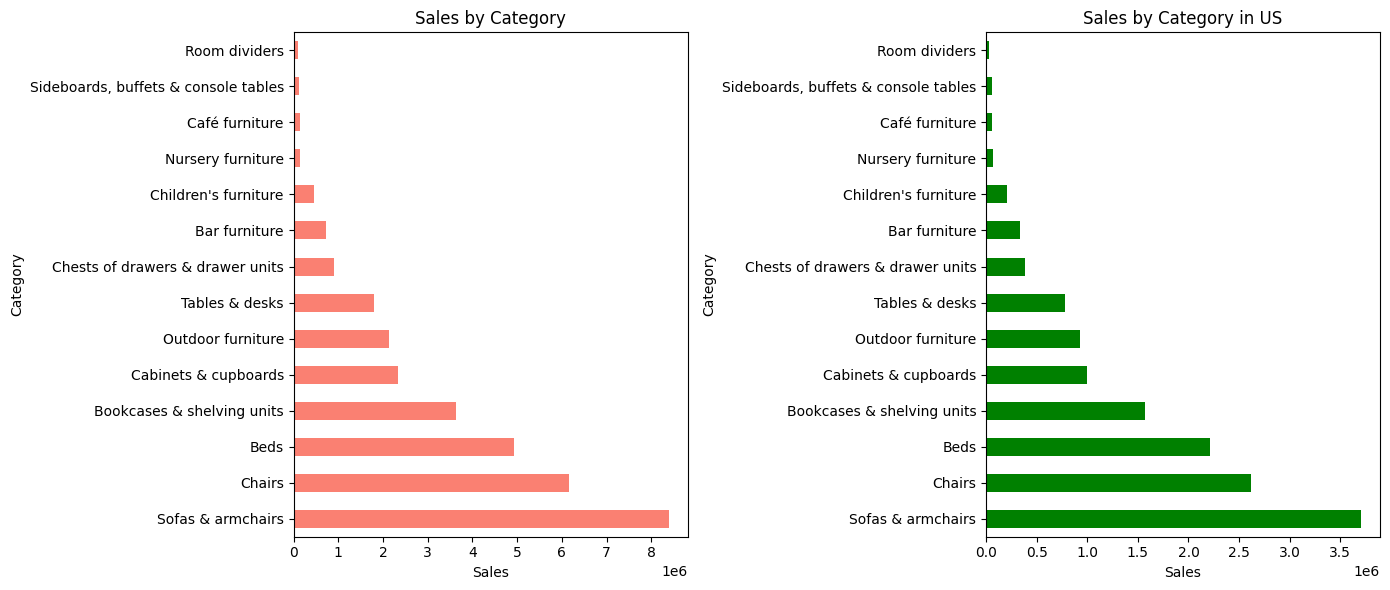

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


top_category.plot(kind = "barh", ax=ax[0], color = "salmon")
ax[0].set_title("Sales by Category")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Category")


top_category_us.plot(kind = "barh", ax=ax[1], color = "green")
ax[1].set_title("Sales by Category in US")
ax[1].set_xlabel("Sales")
ax[1].set_ylabel("Category")

plt.tight_layout()
plt.show()

Найкращі результати показує категорія *Sofas & armchairs*, найгірші - *Room dividers*. Рейтинг продажів за категоріями ідентичний як загалом по країнах, так і окремо у США.

In [ ]:
device_sales = df.groupby("device")["price"].sum().sort_values(ascending=False).reset_index(name="sales")
device_sales.loc[:, "percent_from_total"] = device_sales["sales"] / device_sales["sales"].sum() * 100
print(device_sales)

    device       sales  percent_from_total
0  desktop  18864039.0           59.002245
1   mobile  12384225.8           38.734924
2   tablet    723466.3            2.262831


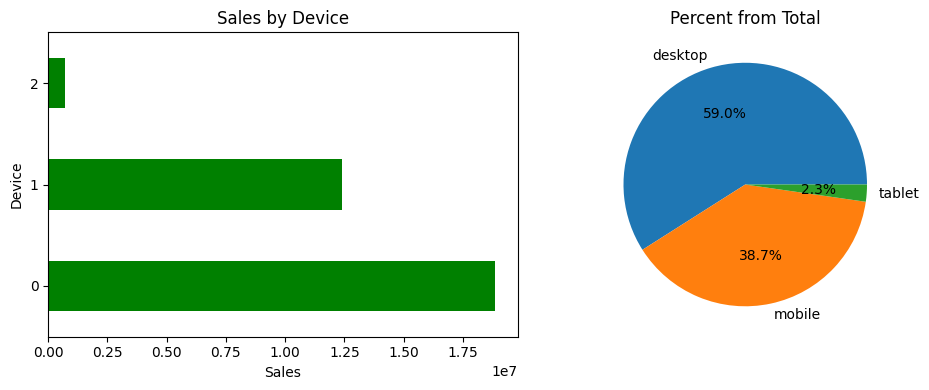

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

device_sales["sales"].plot(kind="barh", ax=ax[0], color="green")
ax[0].set_title("Sales by Device")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Device")

ax[1].pie(device_sales["percent_from_total"], labels=device_sales["device"], autopct='%1.1f%%')
ax[1].set_title("Percent from Total")

plt.tight_layout()

plt.show()

Більшість продажів здійснюється з десктопів (59%), далі йдуть мобільні пристрої (38.7%), тоді як планшети майже не впливають на загальні продажі (2.3%).
Отже, основну увагу варто зосередити на оптимізації для desktop і mobile.

In [ ]:
model_sales = df.groupby("mobile_model_name")["price"].sum().sort_values(ascending=False).reset_index(name="sales")
model_sales.loc[:, "percent_from_total"] = model_sales["sales"] / model_sales["sales"].sum() * 100
print(model_sales)

  mobile_model_name      sales  percent_from_total
0            Chrome  8899523.9           27.835602
1           <Other>  6535330.8           20.440966
2            Safari  6491062.1           20.302504
3            iPhone  6420776.3           20.082667
4        ChromeBook  1830458.7            5.725241
5              Edge   697222.3            2.180746
6              iPad   448854.2            1.403910
7           Firefox   421066.9            1.316998
8        Pixel 4 XL   118287.7            0.369976
9           Pixel 3   109148.2            0.341390


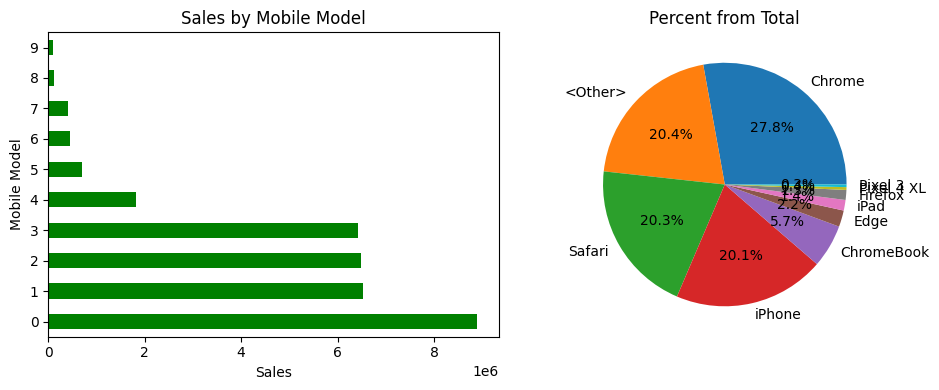

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

model_sales["sales"].plot(kind="barh", ax=ax[0], color="green")
ax[0].set_title("Sales by Mobile Model")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Mobile Model")

ax[1].pie(model_sales["percent_from_total"], labels=model_sales["mobile_model_name"], autopct='%1.1f%%')
ax[1].set_title("Percent from Total")

plt.tight_layout()

plt.show()


Аналіз наданих графіків показує, що найпопулярнішими мобільними моделями за обсягом продажів є *Chrome, Other, Safari, iPhone*, які значно випереджають інші моделі та становлять значну частку у продажах.

In [ ]:
channel_sales = df.groupby("channel")["price"].sum().sort_values(ascending=False).reset_index(name="sales")
channel_sales.loc[:, "percent_from_total"] = channel_sales["sales"] / channel_sales["sales"].sum() * 100
print(channel_sales)

          channel       sales  percent_from_total
0  Organic Search  11433151.6           35.760189
1     Paid Search   8511049.4           26.620546
2          Direct   7494923.4           23.442345
3   Social Search   2532105.7            7.919827
4       Undefined   2000501.0            6.257093


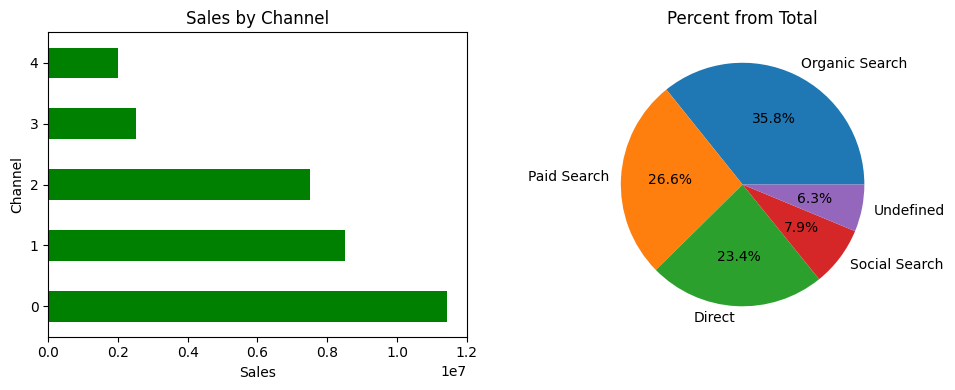

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

channel_sales["sales"].plot(kind="barh", ax=ax[0], color="green")
ax[0].set_title("Sales by Channel")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Channel")

ax[1].pie(channel_sales["percent_from_total"], labels=channel_sales["channel"], autopct='%1.1f%%')
ax[1].set_title("Percent from Total")

plt.tight_layout()

plt.show()

Найвищі продажі за каналами демонструють канали *Organic Search, Paid Search, Direct* та займають основну частку.

In [ ]:
registered_users = df[df["account_id"].notna()]
account_cnt = registered_users["account_id"].count()

is_verified = df[df["is_verified"] == 1]
is_verified_cnt = is_verified["is_verified"].count()
percent_of_verified_accounts = is_verified_cnt / account_cnt * 100

is_unsubscribed = df[df["is_unsubscribed"] == 1]
is_unsubscribed_cnt = is_unsubscribed["is_unsubscribed"].count()
percent_of_unsubscribed_accounts = is_unsubscribed_cnt / account_cnt * 100

print(percent_of_verified_accounts)
print(percent_of_unsubscribed_accounts)

is_unsubscribed_sales = is_unsubscribed["price"].sum()
not_unsubscribed = df[df["is_unsubscribed"] == 0]
not_unsubscribed_sales = not_unsubscribed["price"].sum()

print(is_unsubscribed_sales)
print(not_unsubscribed_sales)

71.69797817140812
16.94399713723385
431721.6
2150796.9


71,7% користувачів підтвердили свою електрону адресу адресу.
Від розсилки відписалося 17% користувачів.
Продажі користувачів, які не відписалися від розсилки є вищими на 20%.

In [ ]:
is_unsubscribed_sales_by_date = is_unsubscribed.groupby("date")["price"].sum().reset_index()
not_unsubscribed_sales_by_date = not_unsubscribed.groupby("date")["price"].sum().reset_index()

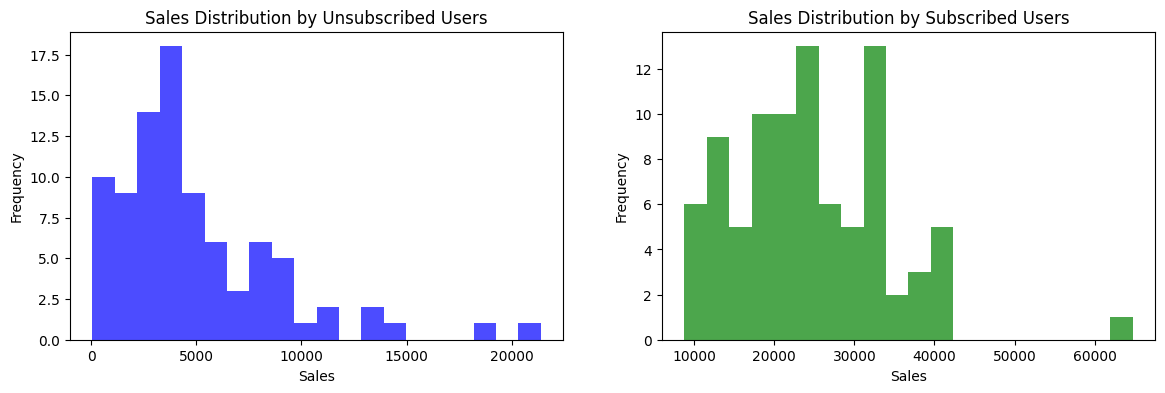

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].hist(is_unsubscribed_sales_by_date, bins=20, color="blue", alpha=0.7)
ax[0].set_title("Sales Distribution by Unsubscribed Users")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Frequency")

ax[1].hist(not_unsubscribed_sales_by_date, bins=20, color="green", alpha=0.7)
ax[1].set_title("Sales Distribution by Subscribed Users")
ax[1].set_xlabel("Sales")
ax[1].set_ylabel("Frequency")

plt.show()

In [ ]:
# Calculate p-value
print(f"Test statistic and p-value: {spearmanr(is_unsubscribed_sales_by_date['price'], not_unsubscribed_sales_by_date['price'])}")

# Calculate Spearman correlation
spearman_corr = is_unsubscribed_sales_by_date["price"].corr(not_unsubscribed_sales_by_date["price"], method="spearman")
print(f"Spearman Correlation: {spearman_corr}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.07738367792610334), pvalue=np.float64(0.4736089665290931))
Spearman Correlation: 0.07738367792610334


Отримавши різницю в продажах між користувачами, які підписані на розсилку і які ні, проаналізувала динаміку продажів за датами, оскільки дані не є нормально розподілені, обрала метод Спірмена для аналізу і отримала такі результати: коефіцієнт кореляція Спірмена ~ 0.07 — дуже слабка позитивна кореляція між поведінкою користувачів, які відписались від розсилки, а які - ні.
Практично зв’язку майже немає.
p-value ≈ 0.495 — значно більше стандартного рівня значущості (0.05).
Це означає, що немає статистично значущої кореляції між цими двома групами.
Інакше кажучи, такі результати продажів можуть виникнути випадково.

In [ ]:
accounts_by_country = df.groupby("country")["account_id"].count().sort_values(ascending=False).reset_index(name="account_cnt")
accounts_by_country.head(10)

,country,account_cnt
0,United States,12384
1,India,2687
2,Canada,2067
3,United Kingdom,859
4,France,553
5,Spain,536
6,Taiwan,500
7,China,490
8,Germany,490
9,Italy,386


In [ ]:
sales_by_date = df.groupby("date")["price"].sum().reset_index()

<Figure size 1600x800 with 0 Axes>

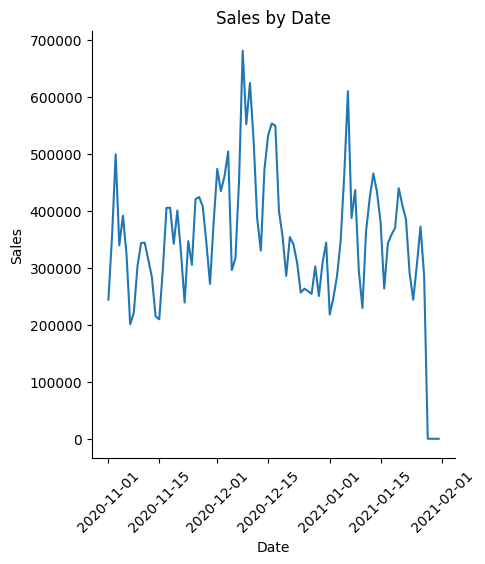

In [ ]:
plt.figure(figsize=(16, 8))
sns.relplot(x="date", y="price", kind="line", data=sales_by_date)
plt.title("Sales by Date")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Sales")
plt.show()

Аналіз динаміки продажів за датами виявляє значну волатильність протягом всього періоду. Спостерігається низка виражених пікових значень, де обсяги продажів сягають понад 600 000 одиниць, що свідчить про періоди високої активності. Після цих піків зазвичай слідують фази спаду. Примітною особливістю є різке, майже обвальне падіння продажів до мінімальних значень наприкінці представленого часового ряду, що може вказувати на суттєву зміну ринкових умов, завершення періоду збору даних, або іншу критичну подію.

In [ ]:
sales_by_date_device = df.groupby(["date", "device"])["price"].sum().reset_index()

<Figure size 1600x800 with 0 Axes>

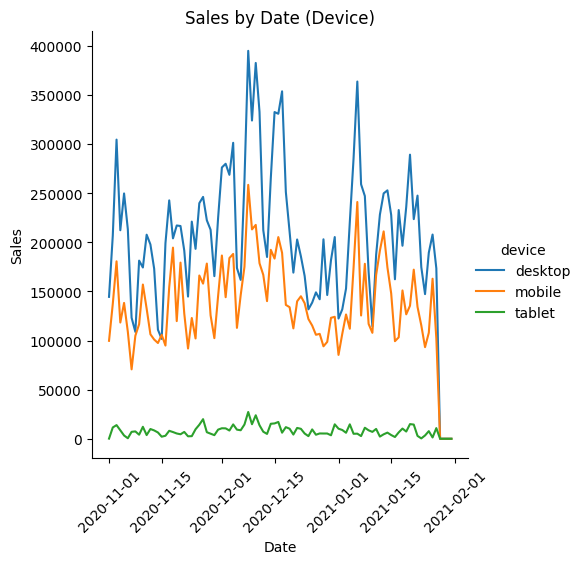

In [ ]:
plt.figure(figsize=(16, 8))
sns.relplot(x="date", y="price", kind="line", data=sales_by_date_device, hue="device")
plt.title("Sales by Date (Device)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Sales")
plt.show()

Графік ілюструє динаміку продажів за пристроями, виявляючи, що десктопні пристрої стабільно генерують найвищі обсяги продажів, демонструючи значну волатильність з кількома піками, що перевищують 350 000 одиниць. Мобільні пристрої посідають друге місце за обсягом продажів, слідуючи аналогічній, хоч і менш вираженій, тенденції коливань. Продажі через планшетні пристрої є мінімальними та відносно стабільними, майже не впливаючи на загальну картину. Важливо відзначити різке падіння продажів наприкінці періоду для всіх типів пристроїв.

In [ ]:
sales_by_date_channel = df.groupby(["date", "channel"])["price"].sum().reset_index()

<Figure size 1600x800 with 0 Axes>

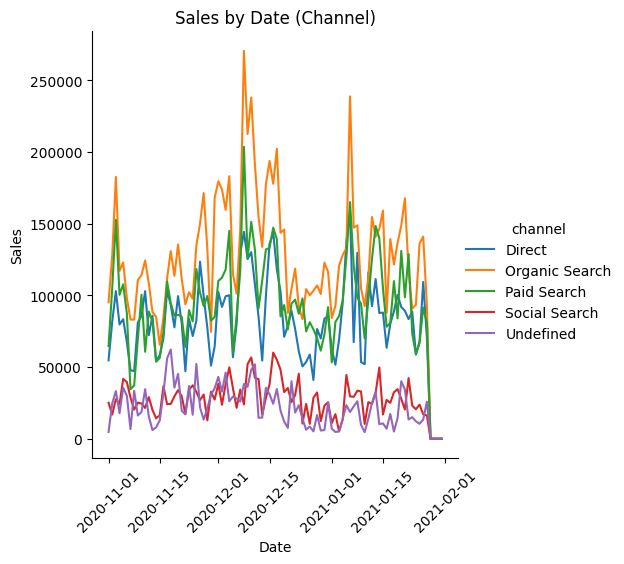

In [ ]:
plt.figure(figsize=(16, 8))
sns.relplot(x="date", y="price", kind="line", data=sales_by_date_channel, hue="channel")
plt.title("Sales by Date (Channel)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Sales")
plt.show()

Продажі через канали *Organic Search* та *Direct* є основними рушіями загального обсягу, демонструючи значну волатильність і періодичні піки, що сягають понад 250 000 і 200 000 продажів відповідно. Канал *Paid Search* також робить суттєвий внесок, слідуючи подібним тенденціям, але з дещо меншими обсягами. На противагу, *Social Search* та *Undefined* канали генерують значно менші, хоча й помітно коливальні обсяги продажів. Для всіх каналів спостерігається різке падіння продажів наприкінці представленого періоду.

In [ ]:
top3_continent = df[df["continent"].isin(["Americas", "Asia", "Europe"])]
sales_by_date_continent = top3_continent.groupby(["date", "continent"])["price"].sum().reset_index()

<Figure size 1600x800 with 0 Axes>

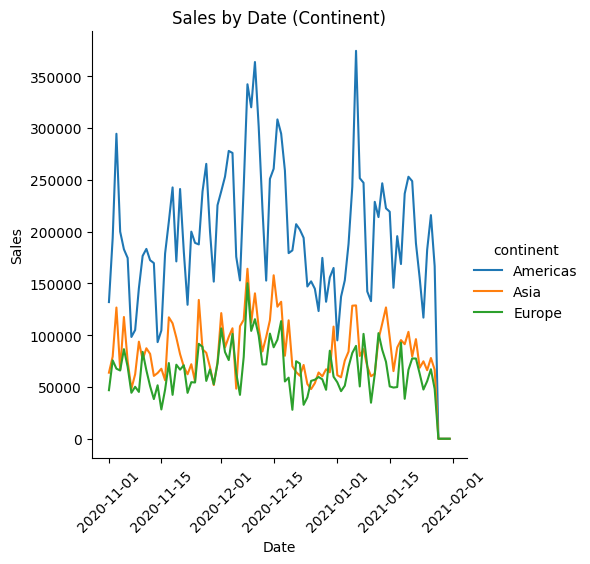

In [ ]:
plt.figure(figsize=(16, 8))
sns.relplot(x="date", y="price", kind="line", data=sales_by_date_continent, hue="continent")
plt.title("Sales by Date (Continent)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Sales")
plt.show()

Аналіз графіка демонструє, що Америка є безумовним лідером за обсягами продажів, генеруючи значно більші показники порівняно з іншими регіонами та виявляючи високу волатильність з періодичними піками, що сягають понад 350 000 продажів. Азія та Європа посідають друге та третє місця відповідно, показуючи схожі, хоча й значно менші, коливання в динаміці продажів.

In [ ]:
top5_country = df[df["country"].isin(["United States", "India", "Canada", "United Kingdom", "France"])]
dynamics_by_country = top5_country.groupby(["date", "country"])["price"].sum().reset_index()

<Figure size 1600x800 with 0 Axes>

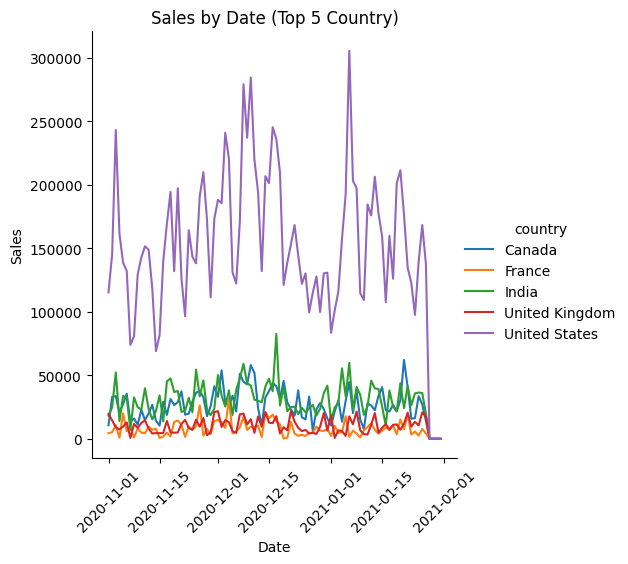

In [ ]:
plt.figure(figsize=(16, 8))
sns.relplot(x="date", y="price", kind="line", data=dynamics_by_country, hue="country")
plt.title("Sales by Date (Top 5 Country)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Sales")
plt.show()

Сполучені Штати є домінуючим ринком, генеруючи значно вищі обсяги продажів порівняно з іншими країнами, та демонструючи помітну волатильність з піками, що перевищують 300 000 одиниць. Канада є другою за обсягом продажів серед представлених країн, але її показники суттєво нижчі за американські, хоча також мають коливальний характер. Продажі у Франції, Індії та Великій Британії знаходяться на значно нижчому рівні та характеризуються відносно невеликими коливаннями.

In [ ]:
pivot_table = pd.pivot_table(df, values="ga_session_id", index="channel", columns="device", aggfunc="count")
print(pivot_table)

device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df.loc[:,"day_name"] = df["date"].dt.day_name()

In [ ]:
pivot_table_2 = pd.pivot_table(df, values=["ga_session_id", "price"], index="day_name", aggfunc=["count"])
print(pivot_table_2)

                  count      
          ga_session_id price
day_name                     
Friday            49603  4586
Monday            50069  4962
Saturday          39523  3724
Sunday            39702  3874
Thursday          54135  5015
Tuesday           58523  5763
Wednesday         57990  5614


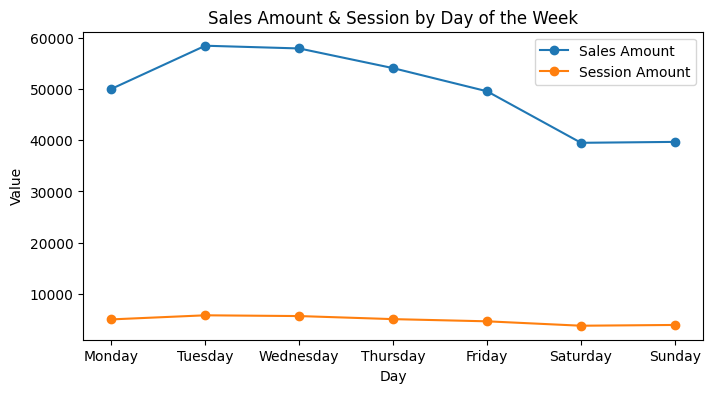

In [ ]:
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_table_2 = pivot_table_2.reindex(ordered_days)

plt.figure(figsize=(8, 4))
for metric in pivot_table_2.columns:
    plt.plot(pivot_table_2.index, pivot_table_2[metric], marker="o")

plt.title("Sales Amount & Session by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Value")
plt.legend(["Sales Amount", "Session Amount"])
plt.show()

In [ ]:
pivot_table_3 = pd.pivot_table(df, values=["ga_session_id", "price"], index="date", aggfunc=["count", "sum"]).reset_index()
print(pivot_table_3)

         date         count                   sum          
              ga_session_id price   ga_session_id     price
0  2020-11-01          2576   281  12838488962552  244292.5
1  2020-11-02          3599   368  17604213672921  355506.8
2  2020-11-03          5173   561  26095074059361  498979.6
3  2020-11-04          4184   370  20818275102910  339187.1
4  2020-11-05          3743   388  18914064866208  391276.6
..        ...           ...   ...             ...       ...
87 2021-01-27          4435   299  22412406047681  286340.7
88 2021-01-28          4112     0  20749000004117       0.0
89 2021-01-29          3700     0  18593522456338       0.0
90 2021-01-30          2845     0  14333437358604       0.0
91 2021-01-31          2812     0  13886261135539       0.0

[92 rows x 5 columns]


In [ ]:
pivot_table_3.columns = ['_'.join(col).strip('_') for col in pivot_table_3.columns.values]
print(pivot_table_3.columns)

Index(['date', 'count_ga_session_id', 'count_price', 'sum_ga_session_id',
       'sum_price'],
      dtype='object')


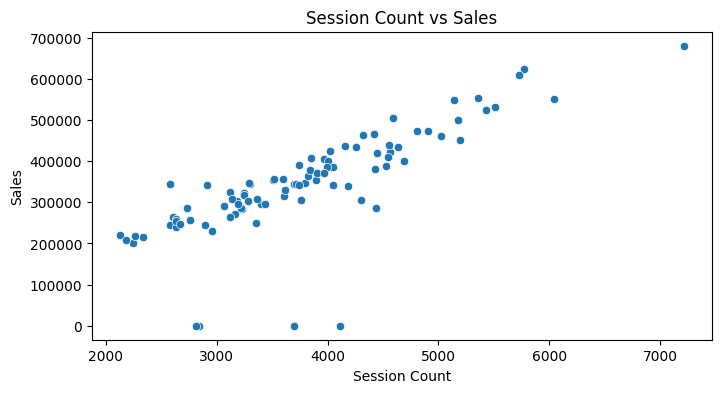

In [ ]:
# Seaborn scatter plot
plt.figure(figsize=(8, 4))
sns.scatterplot(data=pivot_table_3, x="count_ga_session_id", y="sum_price")
plt.title("Session Count vs Sales")
plt.xlabel("Session Count")
plt.ylabel("Sales")
plt.show()

Спостерігається сильна позитивна кореляція між кількістю сесій та продажами. Зі збільшенням кількості сесій, обсяг продажів має виражену тенденцію до зростання. Хоча існують певні варіації та декілька викидів (точки з низькими продажами при високій кількості сесій або навпаки), загальна залежність є лінійною, що свідчить про те, що збільшення трафіку на сайті (виміряного кількістю сесій) прямо пропорційно впливає на збільшення доходу від продажів.

In [ ]:
# Calculate p-value
print(
    f"Test statistic and p-value: {spearmanr(pivot_table_3['count_ga_session_id'], pivot_table_3['sum_price'])}"
)


# Calculate Spearman correlation
spearman_corr = pivot_table_3["count_ga_session_id"].corr(
    pivot_table_3["sum_price"], method="spearman"
)
print(f"Spearman Correlation: {spearman_corr}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.8653062174563682), pvalue=np.float64(9.755923586156614e-29))
Spearman Correlation: 0.8653062174563682


Наявність високого коефіцієнта кореляції Спірмена (0.8653) у поєднанні з надзвичайно низьким p-значенням (<0.001) підтверджує статистично значущу та дуже сильну позитивну монотонну залежність між кількістю сесій та обсягом продажів. Це свідчить про те, що збільшення трафіку (кількості сесій) прямо асоціюється зі зростанням продажів.

In [ ]:
americas_data = df[df["continent"] == "Americas"]
sales_by_americas = americas_data.groupby("date")["price"].sum()

europe_data = df[df["continent"] == "Europe"]
sales_by_europe = europe_data.groupby("date")["price"].sum()

asia_data = df[df["continent"] == "Asia"]
sales_by_asia = asia_data.groupby("date")["price"].sum()
print(sales_by_americas)

date
2020-11-01    132002.5
2020-11-02    193861.0
2020-11-03    294529.8
2020-11-04    200009.5
2020-11-05    182988.2
                ...   
2021-01-27    166735.5
2021-01-28         0.0
2021-01-29         0.0
2021-01-30         0.0
2021-01-31         0.0
Name: price, Length: 92, dtype: float64


In [ ]:
# ANOVA test
f_stat, p_value = f_oneway(sales_by_americas, sales_by_europe, sales_by_asia)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between the continents.")
else:
    print("No statistically significant difference found between the continents.")

F-statistic: 192.934026147625
P-value: 5.891324486218919e-53
There is a statistically significant difference between the continents.


За результатами  аналізу (ANOVA), проведеного для порівняння продажів між континентами (Америка, Європа, Азія), отримано F-статистику 192.93 та p-значення, що становить 5.89×10
−53.

Оскільки p-значення (5.89×10 −53) є значно меншим за прийнятий рівень значущості 0.05, існує статистично значуща різниця в середніх обсягах продажів між континентами. Це вказує на те, що вплив континенту на рівень продажів є суттєвим.

In [ ]:
sales_by_registered_users = registered_users.groupby("date")["price"].sum().reset_index()

In [ ]:
unregistered_users = df[df["account_id"].isna()]
sales_by_unregistered_users = unregistered_users.groupby("date")["price"].sum().reset_index()

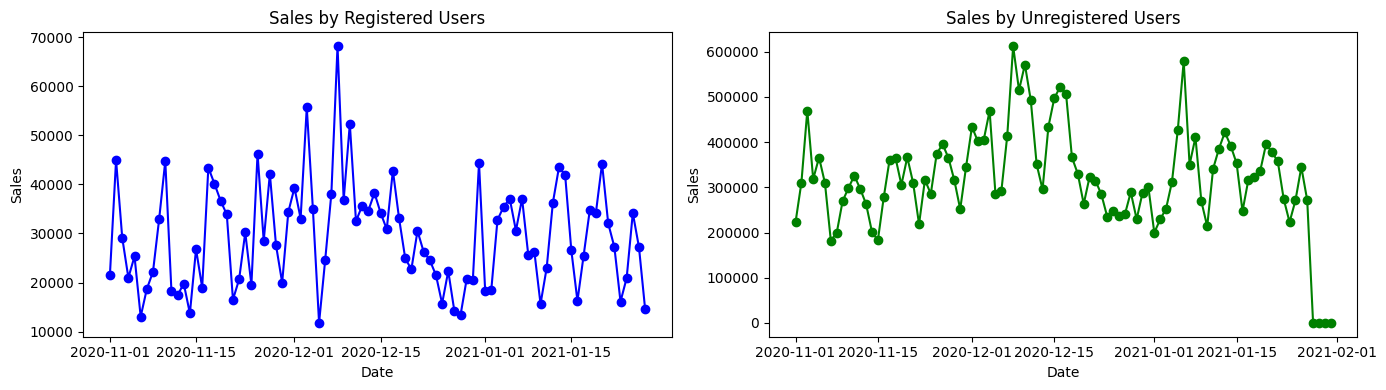

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(sales_by_registered_users, color="blue", marker="o")
ax[0].set_title("Sales by Registered Users")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Sales")

ax[1].plot(sales_by_unregistered_users, color="green", marker="o")
ax[1].set_title("Sales by Unregistered Users")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Sales")

plt.tight_layout()

plt.show()

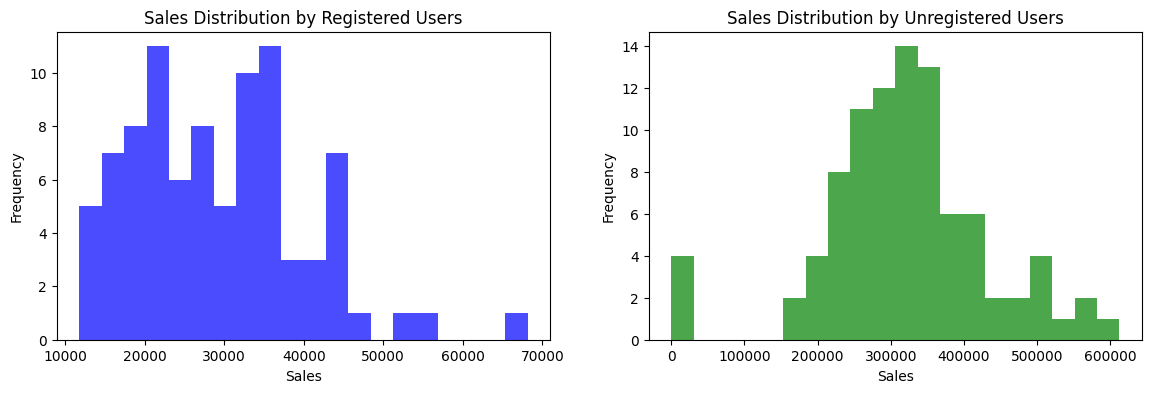

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].hist(sales_by_registered_users, bins=20, color="blue", alpha=0.7)
ax[0].set_title("Sales Distribution by Registered Users")
ax[0].set_xlabel("Sales")
ax[0].set_ylabel("Frequency")

ax[1].hist(sales_by_unregistered_users, bins=20, color="green", alpha=0.7)
ax[1].set_title("Sales Distribution by Unregistered Users")
ax[1].set_xlabel("Sales")
ax[1].set_ylabel("Frequency")

plt.show()

In [ ]:
# Mann-Whitney U test
stat, p_value = mannwhitneyu(sales_by_registered_users["price"], sales_by_unregistered_users["price"])

print(f"U-statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in sales between registered and unregistered users")
else:
    print("There is no significant difference in sales between registered and unregistered users")

U-statistic: 352.0
P-value: 3.8805185465235906e-26
There is a significant difference in sales between registered and unregistered users


Оскільки p-value значно менше 0.05, ми відкидаємо нульову гіпотезу.
Це означає, що різниця в продажах між зареєстрованими та незареєстрованими користувачами є статистично значущою.
Іншими словами, реєстрація впливає на рівень продажів (ймовірно, зареєстровані користувачі купують інакше або більше).

In [ ]:
direct_channel = df[df["channel"] == "Direct"]
session_by_direct = direct_channel.groupby("date")["ga_session_id"].count().reset_index(name="session_cnt")

In [ ]:
organic_channel = df[df["channel"] == "Organic Search"]
session_by_organic = organic_channel.groupby("date")["ga_session_id"].count().reset_index(name="session_cnt")

In [ ]:
paid_channel = df[df["channel"] == "Paid Search"]
session_by_paid = paid_channel.groupby("date")["ga_session_id"].count().reset_index(name="session_cnt")

In [ ]:
undefined_channel = df[df["channel"] == "Undefined"]
session_by_undefined = undefined_channel.groupby("date")["ga_session_id"].count().reset_index(name="session_cnt")

In [ ]:
social_channel = df[df["channel"] == "Social Search"]
session_by_social = social_channel.groupby("date")["ga_session_id"].count().reset_index(name="session_cnt")

In [ ]:
# ANOVA test
f_stat, p_value = f_oneway(
    session_by_direct["session_cnt"], session_by_organic["session_cnt"], session_by_paid["session_cnt"], session_by_undefined["session_cnt"], session_by_social["session_cnt"]
    )

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between the channels.")
else:
    print("No statistically significant difference found between the channels.")


F-statistic: 439.76753169907096
P-value: 8.433830529447596e-155
There is a statistically significant difference between the channels.


Результати однофакторного дисперсійного аналізу (ANOVA) свідчать про наявність статистично значущої різниці між каналами (F = 439.77, p < 0.001). Щонайменше один з каналів суттєво відрізняється за аналізованим показником.
Це свідчить про те, що канал збуту має суттєвий вплив на рівень продажів.

In [ ]:
session_by_channel = df.groupby("channel")["ga_session_id"].count()
print(session_by_channel)

channel
Direct             81382
Organic Search    124425
Paid Search        94341
Social Search      27914
Undefined          21483
Name: ga_session_id, dtype: int64


In [ ]:
filter_data = df[(df["channel"] == "Organic Search") & (df["continent"].isin(["Americas", "Europe"]))]
grouped_data = filter_data.groupby("continent")["ga_session_id"].count().reset_index(name="session_cnt")
print(grouped_data)

session_by_continent = df[df["continent"].isin(["Americas", "Europe"])].groupby("continent")["ga_session_id"].count().reset_index(name="total_session_cnt")
print(session_by_continent)

  continent  session_cnt
0  Americas        68671
1    Europe        23195
  continent  total_session_cnt
0  Americas             193179
1    Europe              65135


In [ ]:
# Data
Americas_total_session_cnt = 193179
Europe_total_session_cnt = 65135
Americas_organic_session_cnt = 68671
Europe_organic_session_cnt = 23195

# z-test for two proportions
z_stat, p_value = sm.stats.proportions_ztest(
    [Americas_organic_session_cnt, Europe_organic_session_cnt], [Americas_total_session_cnt, Europe_total_session_cnt])

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between Americas and Europe.")
else:
    print("No statistically significant difference between Americas and Europe.")

Z-statistic: -0.28951412926103953
P-value: 0.7721879690501752
No statistically significant difference between Americas and Europe.


Оскільки p-значення (0.7722) значно перевищує стандартний рівень значущості 0.05, статистично значущої різниці між Америкою та Європою не виявлено. Це свідчить про те, що будь-які спостережувані відмінності між континентами, ймовірно, є випадковими.

Tableau Public

[Dashboard 1](https://public.tableau.com/views/Project12_17501000550170/Sales?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

[Dashboard 2](https://public.tableau.com/views/Project1_17500998427500/SessionAccounts?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)